## 데이터 분석 프로젝트 🧑
####  카카오페이지 월간 탑 300 로맨스 판타지 장르의 웹소설을 키워드로 분석해 봤습니다.  
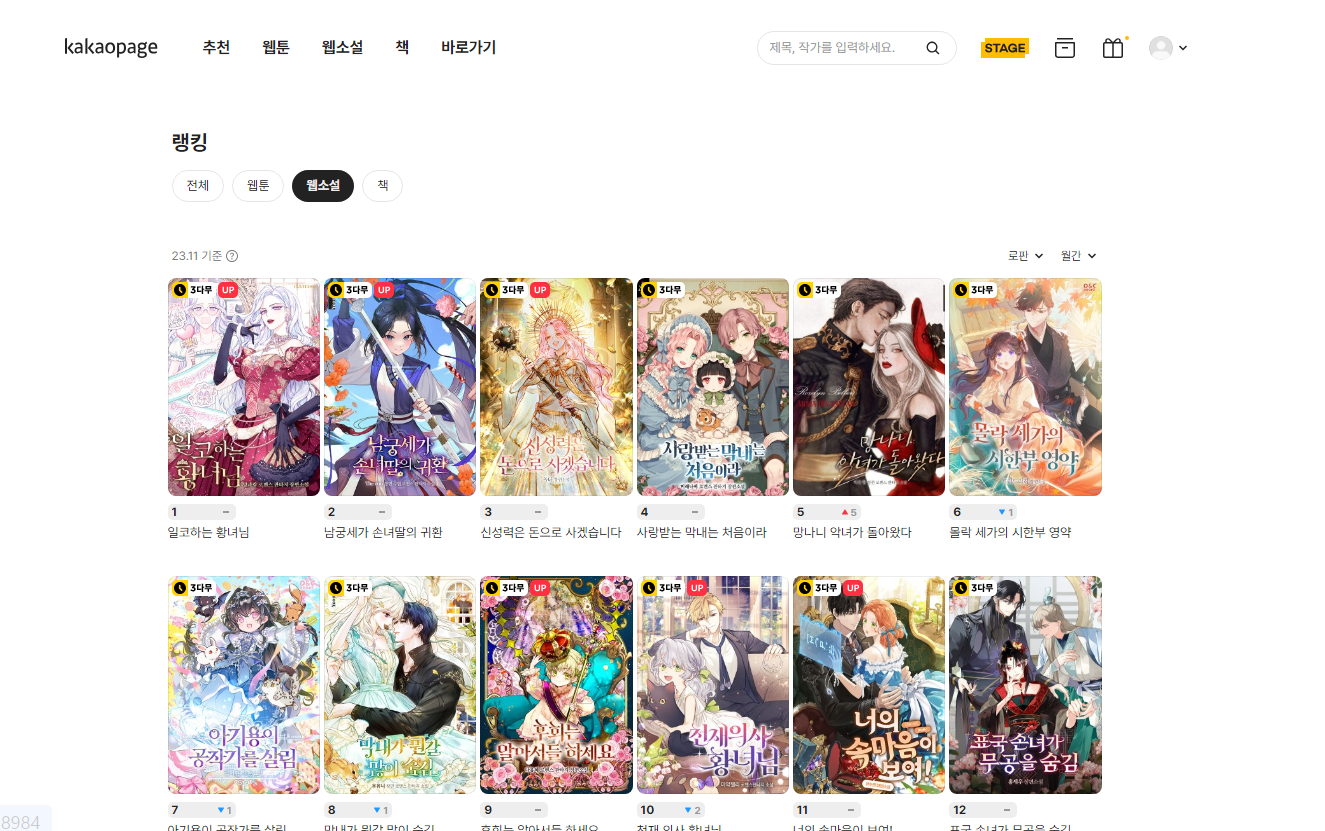

### <1> 크롤링 파트

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#### 1. Selenium 을 이용해 카카오 페이지 탑 300 크롤링

- 동적 크롤링을 해야하기 때문에 Selenium을 이용
- 먼저 탑 300 페이지에서 제목과 해당하는 링크 크롤링

In [ ]:
!pip install selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time

chrome_options = Options()
chrome_options.add_argument("--headless")
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")

driver = webdriver.Chrome(options=chrome_options)

url = "https://page.kakao.com/landing/ranking/11/117?ranking_type=monthly"

driver.get(url)

time.sleep(5)

for _ in range(5):
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(3)

html = driver.page_source

soup = BeautifulSoup(html, 'html.parser')

for link in soup.find_all('a', href=True):
    href = link['href']
    text_content = link.text.strip()
    print(f"Link: {href}, Text: {text_content}")

driver.quit()


In [ ]:
import pandas as pd

with open('/content/untitled', 'r') as file:
    lines = file.readlines()

data = []
for line in lines:
    parts = line.strip().split(', ')
    link = parts[0].replace('Link: ', '')
    text = parts[1].replace('Text: ', '')
    text = ''.join(filter(str.isalpha, text))
    data.append({'Link': link, 'Text': text})

df = pd.DataFrame(data)

df.to_csv('top300.csv', index=False)

df.head()


,Link,Text
0,/content/63018984,일코하는황녀님
1,/content/62961130,남궁세가손녀딸의귀환
2,/content/62962503,신성력은돈으로사겠습니다
3,/content/56382480,사랑받는막내는처음이라
4,/content/62730241,망나니악녀가돌아왔다


#### 2. 샘플로 작품 하나에 대해 키워드 추출해보기  

In [ ]:

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import json

from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(options=chrome_options)

url = 'https://page.kakao.com/content/63018984?tab_type=about'
driver.get(url)

xpath = '//*[@id="__next"]/div/div[2]/div[1]/div[2]/div[2]/div/div/div[2]/div[2]/div'
element = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.XPATH, xpath))
)

html_content = element.get_attribute('outerHTML')

soup = BeautifulSoup(html_content, 'html.parser')

data_t_obj_elements = soup.find_all(attrs={'data-t-obj': True})

copy_values = [json.loads(data_t_obj_element['data-t-obj'])['click']['copy'] for data_t_obj_element in data_t_obj_elements]


In [ ]:
df['New_Link'] = 'https://page.kakao.com' + df['Link'] + '?tab_type=about'
df['키워드'] = ''

#### 3. 작품들에 대해 작품의 about 페이지 방문 => 키워드 추출해서 데이터프레임 ['키워드'] 열에 넣어주기

- 무슨 문제인지 대부분의 페이지는 크롤링이 되었지만, 일부 페이지에서는 크롤링이 되지 않았음. (아마 xpath가 다른 이유일 것이라 추측)
- 크롤링이 되지 않는 경우 try, except 로 예외 처리를 해주고 넘어가도록 했음  

In [ ]:
for index, row in df.head(10).iterrows():
    link = row['New_Link']

    driver.get(link)
    xpath = '//*[@id="__next"]/div/div[2]/div[1]/div[2]/div[2]/div/div/div[2]/div[2]/div'


    element = WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.XPATH, xpath)))

    html_content = element.get_attribute('outerHTML')


    soup = BeautifulSoup(html_content, 'html.parser')

    data_t_obj_elements = soup.find_all(attrs={'data-t-obj': True})


    keywords = [json.loads(element['data-t-obj'])['click']['copy'] for element in data_t_obj_elements]
    df.at[index, '키워드'] = ', '.join(keywords)


driver.quit()


df.head()

,Link,Text,New_Link,키워드
0,/content/63018984,일코하는황녀님,https://page.kakao.com/content/63018984?tab_ty...,"로맨스판타지, 환생물, 짝사랑, 운명, 존댓말남, 집착남, 소유욕/독점욕, 상처남,..."
1,/content/62961130,남궁세가손녀딸의귀환,https://page.kakao.com/content/62961130?tab_ty...,"로맨스판타지, 먼치킨, 환생물, 무협물, 가족물"
2,/content/62962503,신성력은돈으로사겠습니다,https://page.kakao.com/content/62962503?tab_ty...,"로맨스판타지, 차원이동물, 환생물, 능글남, 다정남, 유혹남, 존댓말남, 능력녀, ..."
3,/content/56382480,사랑받는막내는처음이라,https://page.kakao.com/content/56382480?tab_ty...,"로맨스판타지, 육아물, 먼치킨, 환생물, 시한부, 집착남, 대형견남, 직진남, 능력..."
4,/content/62730241,망나니악녀가돌아왔다,https://page.kakao.com/content/62730241?tab_ty...,"로맨스판타지, 왕족/귀족, 악녀, 드라마"


In [ ]:

from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import json

from selenium.webdriver.chrome.options import Options
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

driver = webdriver.Chrome(options=chrome_options)


In [ ]:
from selenium.common.exceptions import TimeoutException

for index, row in df.iterrows():
    link = row['New_Link']

    xpath = '//*[@id="__next"]/div/div[2]/div[1]/div[2]/div[2]/div/div/div[2]/div[2]/div'

    try:
        driver.get(link)
        element = WebDriverWait(driver, 30).until(
            EC.visibility_of_element_located((By.XPATH, xpath))
        )

    except TimeoutException:
        print(f"TimeoutException: Unable to find element on {link}. Skipping to the next page.")
        continue
    except Exception as e:
        print(f"An error occurred on {link}: {e}. Skipping to the next page.")
        continue

    html_content = element.get_attribute('outerHTML')

    soup = BeautifulSoup(html_content, 'html.parser')

    data_t_obj_elements = soup.find_all(attrs={'data-t-obj': True})

    try:
        keywords = [json.loads(element['data-t-obj'])['click']['copy'] for element in data_t_obj_elements]
        df.at[index, '키워드'] = ', '.join(keywords)
    except KeyError:
        print(f"KeyError: Unable to find 'copy' key on {link}. Skipping to the next page.")

driver.quit()

df.head()

TimeoutException: Unable to find element on https://page.kakao.com/content/59181509?tab_type=about. Skipping to the next page.
TimeoutException: Unable to find element on https://page.kakao.com/content/62655415?tab_type=about. Skipping to the next page.
TimeoutException: Unable to find element on https://page.kakao.com/content/56603128?tab_type=about. Skipping to the next page.
TimeoutException: Unable to find element on https://page.kakao.com/content/63044948?tab_type=about. Skipping to the next page.
TimeoutException: Unable to find element on https://page.kakao.com/content/60558545?tab_type=about. Skipping to the next page.
TimeoutException: Unable to find element on https://page.kakao.com/content/63212838?tab_type=about. Skipping to the next page.
TimeoutException: Unable to find element on https://page.kakao.com/content/60512058?tab_type=about. Skipping to the next page.
TimeoutException: Unable to find element on https://page.kakao.com/content/52261981?tab_type=about. Skipping to

,Link,Text,New_Link,키워드
0,/content/63018984,일코하는황녀님,https://page.kakao.com/content/63018984?tab_ty...,"로맨스판타지, 환생물, 짝사랑, 운명, 존댓말남, 집착남, 소유욕/독점욕, 상처남,..."
1,/content/62961130,남궁세가손녀딸의귀환,https://page.kakao.com/content/62961130?tab_ty...,"로맨스판타지, 먼치킨, 환생물, 무협물, 가족물"
2,/content/62962503,신성력은돈으로사겠습니다,https://page.kakao.com/content/62962503?tab_ty...,"로맨스판타지, 차원이동물, 환생물, 능글남, 다정남, 유혹남, 존댓말남, 능력녀, ..."
3,/content/56382480,사랑받는막내는처음이라,https://page.kakao.com/content/56382480?tab_ty...,"로맨스판타지, 육아물, 먼치킨, 환생물, 시한부, 집착남, 대형견남, 직진남, 능력..."
4,/content/62730241,망나니악녀가돌아왔다,https://page.kakao.com/content/62730241?tab_ty...,"로맨스판타지, 왕족/귀족, 악녀, 드라마"


In [ ]:
df

,Link,Text,New_Link,키워드
0,/content/63018984,일코하는황녀님,https://page.kakao.com/content/63018984?tab_ty...,"로맨스판타지, 환생물, 짝사랑, 운명, 존댓말남, 집착남, 소유욕/독점욕, 상처남,..."
1,/content/62961130,남궁세가손녀딸의귀환,https://page.kakao.com/content/62961130?tab_ty...,"로맨스판타지, 먼치킨, 환생물, 무협물, 가족물"
2,/content/62962503,신성력은돈으로사겠습니다,https://page.kakao.com/content/62962503?tab_ty...,"로맨스판타지, 차원이동물, 환생물, 능글남, 다정남, 유혹남, 존댓말남, 능력녀, ..."
3,/content/56382480,사랑받는막내는처음이라,https://page.kakao.com/content/56382480?tab_ty...,"로맨스판타지, 육아물, 먼치킨, 환생물, 시한부, 집착남, 대형견남, 직진남, 능력..."
4,/content/62730241,망나니악녀가돌아왔다,https://page.kakao.com/content/62730241?tab_ty...,"로맨스판타지, 왕족/귀족, 악녀, 드라마"
...,...,...,...,...
295,/content/50562617,치트라미남을뽑는여백작완결,https://page.kakao.com/content/50562617?tab_ty...,
296,/content/49412304,시녀로살아남기,https://page.kakao.com/content/49412304?tab_ty...,
297,/content/51152509,달빛도서관,https://page.kakao.com/content/51152509?tab_ty...,
298,/content/55592610,상냥한남자주인공의가면을벗기면,https://page.kakao.com/content/55592610?tab_ty...,"남장여자물, 빙의물, 남장여자, 소유욕/독점욕, 직진남, 능력녀"


In [ ]:

csv_file_path = 'top300_kakao_rf.csv'
selected_columns = ['Text', '키워드']
selected_df = df[selected_columns]
selected_df.to_csv(csv_file_path, index=False)

print(f"DataFrame successfully exported to: {csv_file_path}")


DataFrame successfully exported to: top300_kakao_rf.csv
